## Data Loading

In [2]:
%pip install netCDF4 h5netcdf xarray pandas "numpy<2" matplotlib seaborn packaging scipy store statsmodels plotly nbformat pmdarima


Note: you may need to restart the kernel to use updated packages.


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Assuming your .nc file is named 'microplastic_data.nc'
ds = xr.open_dataset('/Users/autinauyeung/arima-mircoplastic/data/cyg.ddmi.s20180816-120000-e20180816-120000.l3.grid-microplastic.a32.d33.nc', engine='netcdf4')
ds = ds.to_dataframe().reset_index()
ds = ds.dropna()
ds

,time,lat,lon,num_mp_samples,stddev_mp_samples,mp_concentration
0,2018-08-16 12:00:00,-37.0,0.00,817.0,0.135344,12866.504883
1,2018-08-16 12:00:00,-37.0,0.25,814.0,0.130202,12746.297852
2,2018-08-16 12:00:00,-37.0,0.50,812.0,0.125060,12626.090820
3,2018-08-16 12:00:00,-37.0,0.75,810.0,0.119918,12505.883789
4,2018-08-16 12:00:00,-37.0,1.00,808.0,0.114776,12385.675781
...,...,...,...,...,...,...
427675,2018-08-16 12:00:00,37.0,358.75,378.0,0.164024,13963.895508
427676,2018-08-16 12:00:00,37.0,359.00,472.0,0.162074,14053.669922
427677,2018-08-16 12:00:00,37.0,359.25,522.0,0.162901,13929.945312
427678,2018-08-16 12:00:00,37.0,359.50,572.0,0.163729,13806.220703


## Data Processing

Single File Investigation 

Investigation Area: 
Latitutde: -30.5 and 17.25 
Longitutde: 72 and 215.25 

In [5]:
subset = ds.where(
    (ds['lat'] >= -30.5) & (ds['lat'] <= 17.25) &
    (ds['lon'] >= 72) & (ds['lon'] <= 215.25)).dropna()
subset

,time,lat,lon,num_mp_samples,stddev_mp_samples,mp_concentration
37728,2018-08-16 12:00:00,-30.50,72.00,923.0,0.183145,12876.937500
37729,2018-08-16 12:00:00,-30.50,72.25,913.0,0.183003,12908.672852
37730,2018-08-16 12:00:00,-30.50,72.50,903.0,0.182860,12940.408203
37731,2018-08-16 12:00:00,-30.50,72.75,893.0,0.182717,12972.144531
37732,2018-08-16 12:00:00,-30.50,73.00,884.0,0.182575,13003.879883
...,...,...,...,...,...,...
313337,2018-08-16 12:00:00,17.25,214.25,861.0,0.141743,12359.061523
313338,2018-08-16 12:00:00,17.25,214.50,832.0,0.142005,12329.065430
313339,2018-08-16 12:00:00,17.25,214.75,803.0,0.142266,12299.068359
313340,2018-08-16 12:00:00,17.25,215.00,774.0,0.142528,12269.072266


In [6]:
total_mp = subset['mp_concentration'].sum()
print(total_mp)

1245180000.0


In [7]:
lat_min, lat_max = -30.5, 17.25
lon_min, lon_max = 72, 215.25

# Area in degrees^2
area_deg2 = (lat_max - lat_min) * (lon_max - lon_min)

# Area in km^2 (approximate, using mean latitude)
mean_lat = (lat_min + lat_max) / 2
lat_km = 111 * (lat_max - lat_min)
lon_km = 111 * np.cos(np.deg2rad(mean_lat)) * (lon_max - lon_min)
area_km2 = lat_km * lon_km

print(area_km2)

83715185.88151443


In [8]:
avg_mp = total_mp / area_km2
print(avg_mp)

14.87400426682866


In [9]:
type(subset['time'])

pandas.core.series.Series

In [10]:
date = pd.to_datetime(subset['time'].values[0]).date()
print(date)

2018-08-16


Load more data

In [11]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
from tqdm import tqdm

# Japan Coordinate 
# 30.06184,128.59829
# 36.87705,145.45533


lat_min, lat_max = 30.06184,128.59829
lon_min, lon_max = 36.87705,145.45533

mean_lat = (lat_min + lat_max) / 2
lat_km = 111 * (lat_max - lat_min)
lon_km = 111 * np.cos(np.deg2rad(mean_lat)) * (lon_max - lon_min)
area_km2 = lat_km * lon_km

results = []

data_folder = 'data'

files = [file for file in os.listdir(data_folder)]


In [13]:
len(files)

2488

In [14]:
for file in tqdm(files, desc='Processing NetCDF files'):
    if file.endswith('.nc'):
        file_path=os.path.join(data_folder, file)
        ds = xr.open_dataset(file_path)
        ds = ds.to_dataframe().reset_index()
        ds = ds.dropna()

        subset = ds.where(
            (ds['lat'] >= lat_min) & (ds['lat'] <= lat_max) &
            (ds['lon'] >= lon_min) & (ds['lon'] <= lon_max)).dropna()

        total_mp = subset['mp_concentration'].sum()

        avg_mp = total_mp / area_km2

        date = pd.to_datetime(subset['time'].values[0]).date()

        results.append({'time': date, 'mp_concentration': avg_mp})

results 

Processing NetCDF files:  13%|█▎        | 322/2488 [00:39<04:27,  8.10it/s]


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(results)
df.to_csv("mp_conc_updated_japan.csv", index=False)
df

,time,mp_concentration
0,2021-11-25,1.074025
1,2021-08-24,1.103620
2,2024-12-01,1.072041
3,2024-05-13,1.073601
4,2025-02-24,1.044481
...,...,...
2481,2021-11-05,1.086830
2482,2024-12-21,1.078703
2483,2021-06-17,1.114130
2484,2020-01-20,1.074720


In [ ]:
df = pd.read_csv('mp_conc_updated_japan.csv')
df = df.sort_values('time').reset_index().drop(columns=['index'])
df.to_csv("mp_conc_sorted_japan.csv", index=False)
df

,time,mp_concentration
0,2018-08-16,1.043664
1,2018-08-17,1.045588
2,2018-08-18,1.056034
3,2018-08-19,1.062851
4,2018-08-20,1.064524
...,...,...
2481,2025-06-01,1.098284
2482,2025-06-02,1.097997
2483,2025-06-03,1.097611
2484,2025-06-04,1.086632


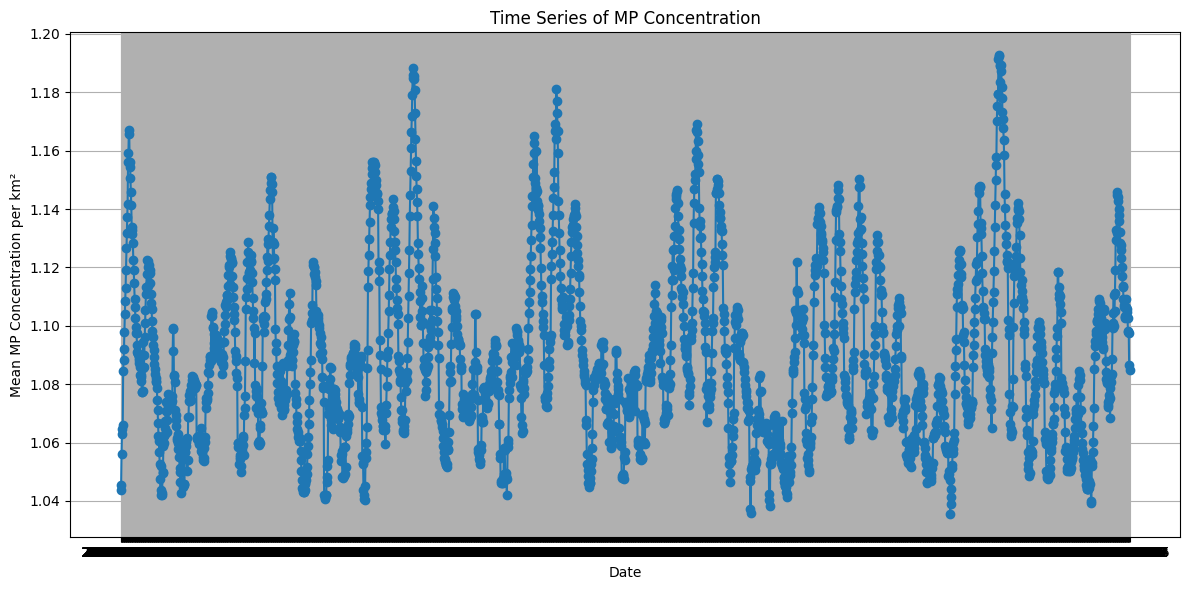

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['mp_concentration'], marker='o')
plt.xlabel('Date')
plt.ylabel('Mean MP Concentration per km²')
plt.title('Time Series of MP Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
df = pd.read_csv('mp_conc_sorted.csv')
df['time'] = pd.to_datetime(df['time'])
df = df.set_index('time')
df

,mp_concentration
time,
2018-08-16,1.043664
2018-08-17,1.045588
2018-08-18,1.056034
2018-08-19,1.062851
2018-08-20,1.064524
...,...
2025-06-01,1.098284
2025-06-02,1.097997
2025-06-03,1.097611


In [ ]:
weekly_df = df.resample('W').mean()
weekly_df.dropna()
weekly_df.to_csv('mp_conc_weekly.csv')
weekly_df

,mp_concentration
time,
2018-08-19,1.052034
2018-08-26,1.085368
2018-09-02,1.125435
2018-09-09,1.158474
2018-09-16,1.133728
...,...
2025-05-11,1.141632
2025-05-18,1.124967
2025-05-25,1.108001


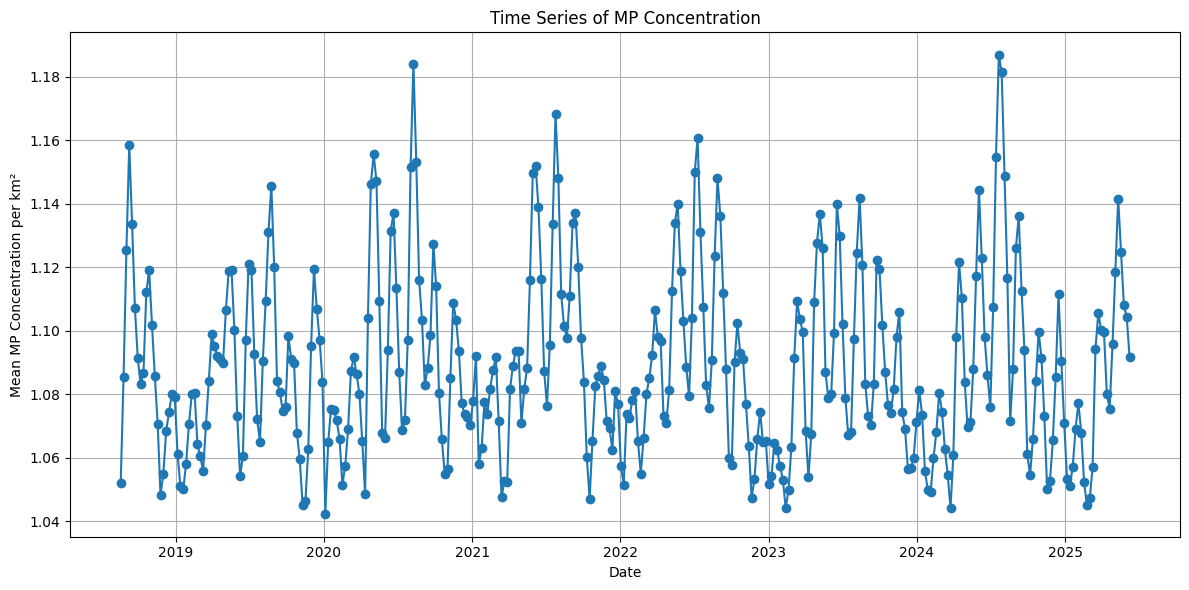

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_df.index, weekly_df['mp_concentration'], marker='o')
plt.xlabel('Date')
plt.ylabel('Mean MP Concentration per km²')
plt.title('Time Series of MP Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
monthly_df = df.resample('M').mean()
monthly_df.dropna()
monthly_df.to_csv('mp_conc_monthly.csv')

/var/folders/j9/ndmp7tg95qjck81gbd4gdfy00000gn/T/ipykernel_46839/200660968.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



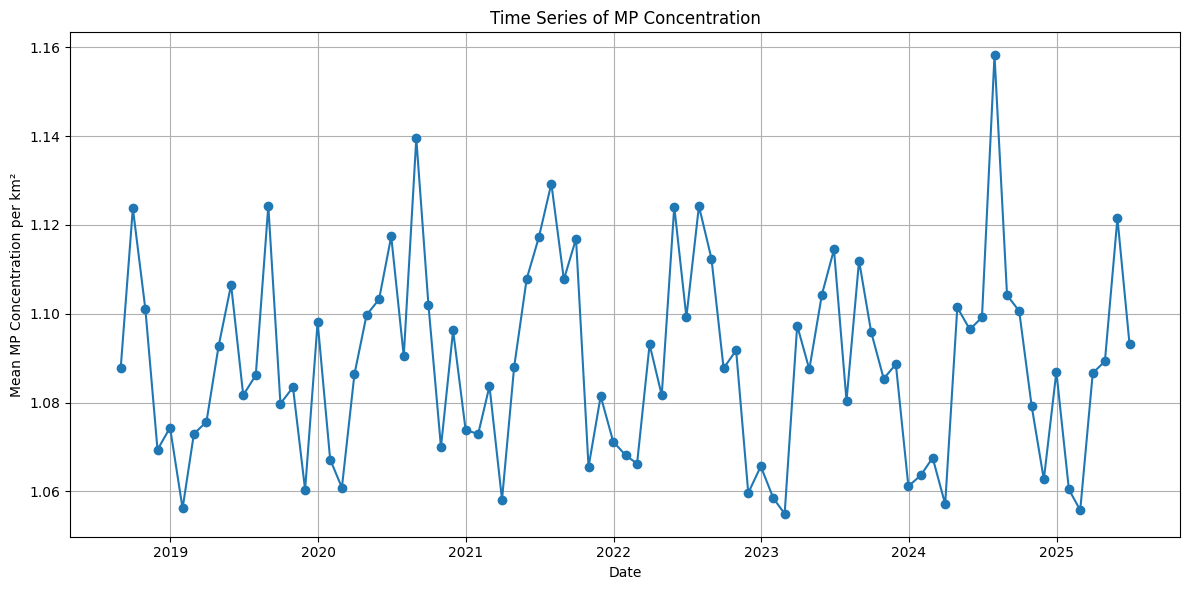

In [ ]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(monthly_df.index, monthly_df['mp_concentration'], marker='o')
plt.xlabel('Date')
plt.ylabel('Mean MP Concentration per km²')
plt.title('Time Series of MP Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

## Stationarity 

In [ ]:
data = pd.read_csv("mp_conc_monthly.csv")
data

,time,mp_concentration
0,2018-08-31,1.087805
1,2018-09-30,1.123763
2,2018-10-31,1.100991
3,2018-11-30,1.069375
4,2018-12-31,1.074347
...,...,...
78,2025-02-28,1.055754
79,2025-03-31,1.086630
80,2025-04-30,1.089276
81,2025-05-31,1.121518


In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    test_results = adfuller(series)
    print("ADF Statistic: ", test_results[0])
    print("p-value: ", test_results[1])
    print("Critical values: ")
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

adf_test(data['mp_concentration'][:])

ADF Statistic:  -1.7245746256951517
p-value:  0.4184974307323111
Critical values: 
	1%: -3.53
	5%: -2.90
	10%: -2.59


In [ ]:
def plot_graph(df: pd.DataFrame, y: str):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df[y], marker='o')
    plt.xlabel('Date')
    plt.ylabel('Mean MP Concentration per km²')
    plt.title('Time Series of '+ y)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
from scipy.stats import boxcox

data['mp_conc_boxcox'], lam = boxcox(data['mp_concentration'])
data['mp_conc_diff'] = data['mp_concentration'].diff()
data['mp_conc_log'] = np.log(data['mp_concentration'])
data['mp_conc_logndiff'] = data['mp_conc_log'].diff()
data

,time,mp_concentration,mp_conc_boxcox,mp_conc_diff,mp_conc_log,mp_conc_logndiff
0,2018-08-31,1.087805,0.058139,NaN,0.084162,NaN
1,2018-09-30,1.123763,0.070832,0.035958,0.116683,0.032521
2,2018-10-31,1.100991,0.063300,-0.022772,0.096211,-0.020472
3,2018-11-30,1.069375,0.049741,-0.031616,0.067074,-0.029137
4,2018-12-31,1.074347,0.052156,0.004972,0.071713,0.004639
...,...,...,...,...,...,...
78,2025-02-28,1.055754,0.042492,-0.004657,0.054256,-0.004401
79,2025-03-31,1.086630,0.057647,0.030876,0.083082,0.028826
80,2025-04-30,1.089276,0.058748,0.002646,0.085514,0.002432
81,2025-05-31,1.121518,0.070158,0.032241,0.114683,0.029169


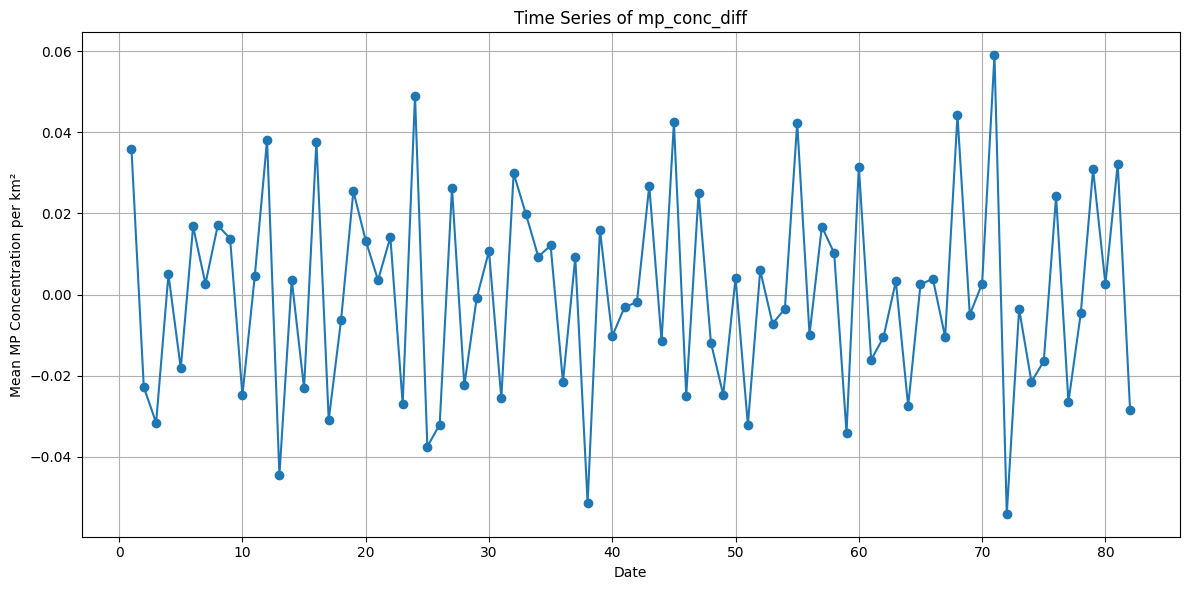

ADF Statistic:  -6.929349879737195
p-value:  1.0942549556393906e-09
Critical values: 
	1%: -3.53
	5%: -2.90
	10%: -2.59


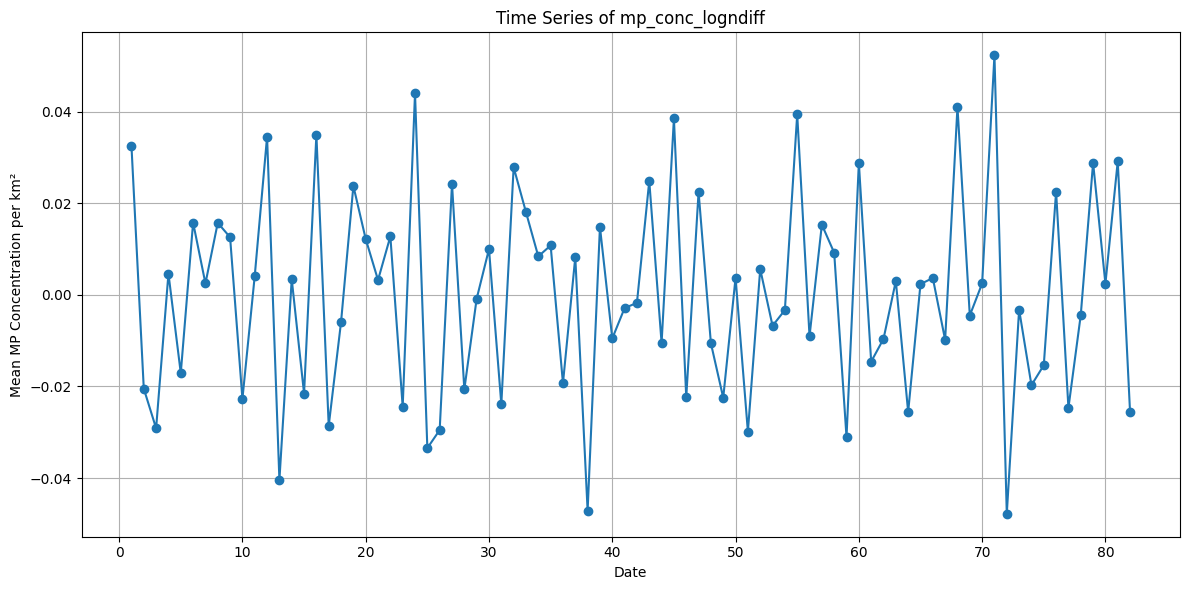

ADF Statistic:  -6.965579294570467
p-value:  8.933020894855507e-10
Critical values: 
	1%: -3.53
	5%: -2.90
	10%: -2.59


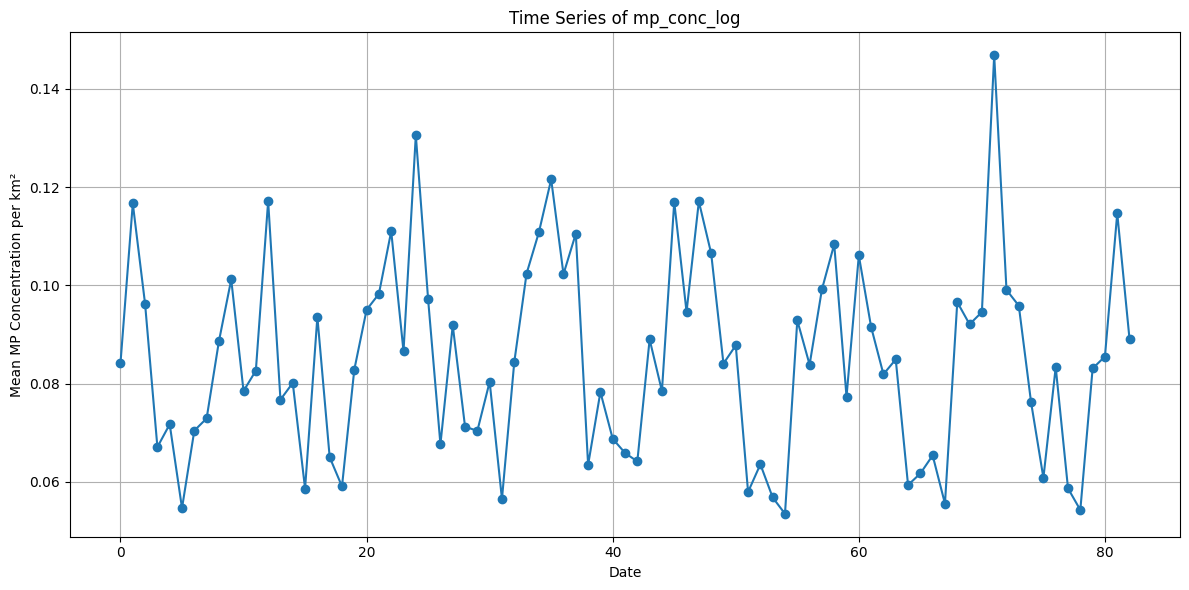

ADF Statistic:  -1.7208086595798613
p-value:  0.4204243734575157
Critical values: 
	1%: -3.53
	5%: -2.90
	10%: -2.59


In [ ]:
plot_graph(data, 'mp_conc_diff')
adf_test(data['mp_conc_diff'][1:])
plot_graph(data, 'mp_conc_logndiff')
adf_test(data['mp_conc_logndiff'][1:])
plot_graph(data, 'mp_conc_log')
adf_test(data['mp_conc_log'][:])





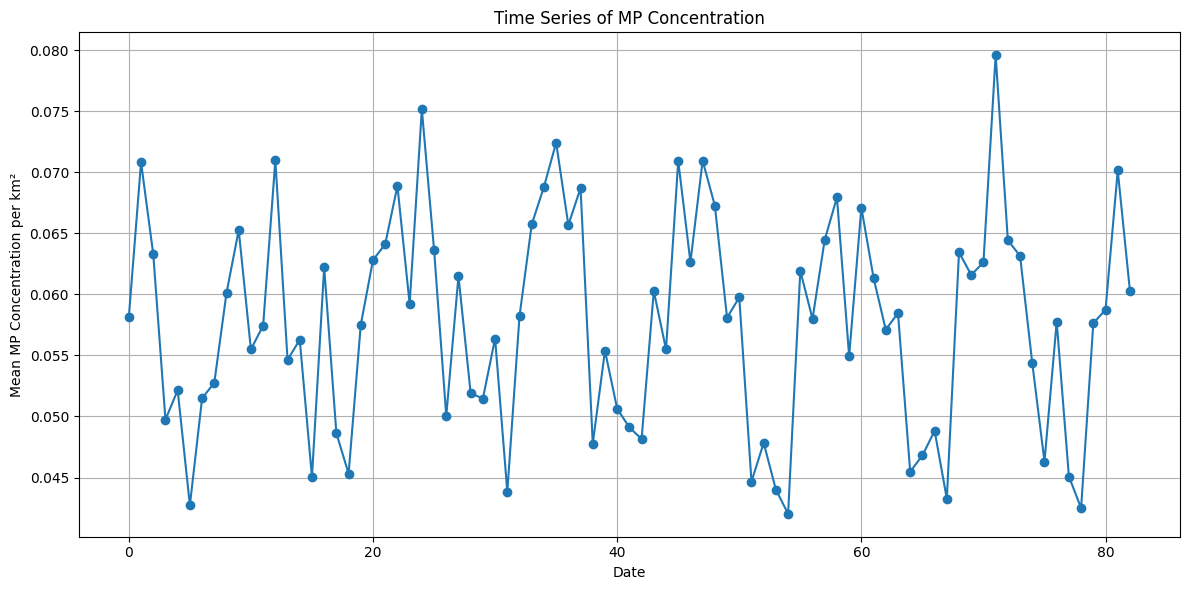

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['mp_conc_boxcox'], marker='o')
plt.xlabel('Date')
plt.ylabel('Mean MP Concentration per km²')
plt.title('Time Series of MP Concentration')
plt.grid(True)
plt.tight_layout()
plt.show()

The distribution itself is normal enough given the initial ADF test on microplastic data. All we need is to remove seasonality and perhaps assess the necesscity of doing logarithmic transform. 

## Decomposition

In [ ]:
data = data.set_index('time')

In [ ]:
data.dropna()

,mp_concentration,mp_conc_boxcox,mp_conc_diff,mp_conc_log,mp_conc_logndiff
time,,,,,
2018-09-30,1.123763,0.070832,0.035958,0.116683,0.032521
2018-10-31,1.100991,0.063300,-0.022772,0.096211,-0.020472
2018-11-30,1.069375,0.049741,-0.031616,0.067074,-0.029137
2018-12-31,1.074347,0.052156,0.004972,0.071713,0.004639
2019-01-31,1.056156,0.042720,-0.018191,0.054636,-0.017077
...,...,...,...,...,...
2025-02-28,1.055754,0.042492,-0.004657,0.054256,-0.004401
2025-03-31,1.086630,0.057647,0.030876,0.083082,0.028826
2025-04-30,1.089276,0.058748,0.002646,0.085514,0.002432


In [ ]:
data.index = pd.to_datetime(data.index)
data

,mp_concentration,mp_conc_boxcox,mp_conc_diff,mp_conc_log,mp_conc_logndiff
time,,,,,
2018-08-31,1.087805,0.058139,NaN,0.084162,NaN
2018-09-30,1.123763,0.070832,0.035958,0.116683,0.032521
2018-10-31,1.100991,0.063300,-0.022772,0.096211,-0.020472
2018-11-30,1.069375,0.049741,-0.031616,0.067074,-0.029137
2018-12-31,1.074347,0.052156,0.004972,0.071713,0.004639
...,...,...,...,...,...
2025-02-28,1.055754,0.042492,-0.004657,0.054256,-0.004401
2025-03-31,1.086630,0.057647,0.030876,0.083082,0.028826
2025-04-30,1.089276,0.058748,0.002646,0.085514,0.002432


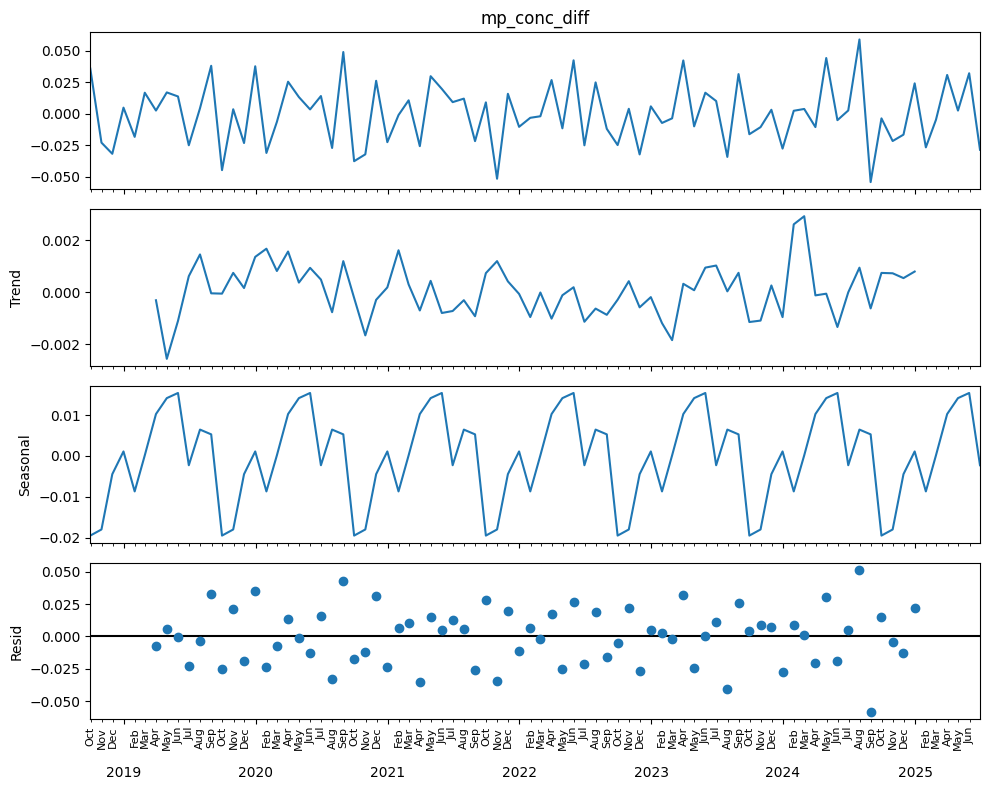

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

decomposition_plot_add = seasonal_decompose(data['mp_conc_diff'][1:],
                                            model='additive')
fig = decomposition_plot_add.plot()
fig.set_size_inches(10,8)

date_format = mdates.DateFormatter('%Y-%m') # Define the format: Year-Month

for ax in fig.axes:
    ax.xaxis.set_major_formatter(date_format)
    
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center") 

    ax.tick_params(axis='x', which='major', pad=30)

    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b')) 
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=90, fontsize=8) 

plt.tight_layout()
plt.show()


## ACF & PACF

In [ ]:
data = data.dropna()
data

,mp_concentration,mp_conc_boxcox,mp_conc_diff,mp_conc_log,mp_conc_logndiff
time,,,,,
2018-09-30,1.123763,0.070832,0.035958,0.116683,0.032521
2018-10-31,1.100991,0.063300,-0.022772,0.096211,-0.020472
2018-11-30,1.069375,0.049741,-0.031616,0.067074,-0.029137
2018-12-31,1.074347,0.052156,0.004972,0.071713,0.004639
2019-01-31,1.056156,0.042720,-0.018191,0.054636,-0.017077
...,...,...,...,...,...
2025-02-28,1.055754,0.042492,-0.004657,0.054256,-0.004401
2025-03-31,1.086630,0.057647,0.030876,0.083082,0.028826
2025-04-30,1.089276,0.058748,0.002646,0.085514,0.002432


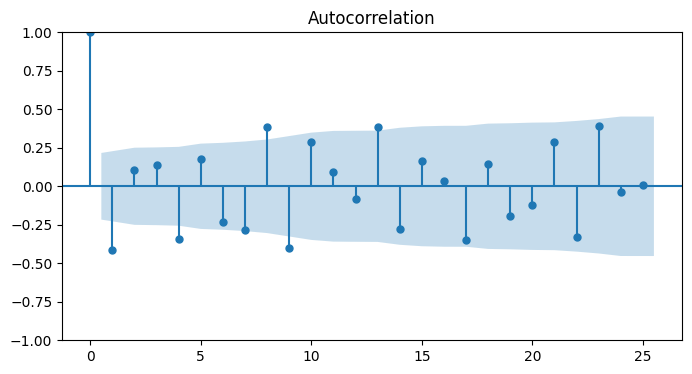

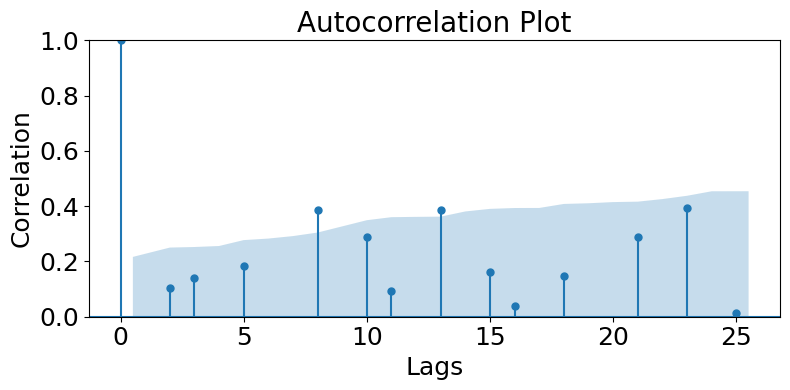

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(8,4))
plot_acf(data['mp_conc_diff'], lags=25)
plot_acf(data['mp_conc_logndiff'], lags=25)
plt.ylim(0,1)
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

We observe the following: 
- There is a cyclical pattern in the lags every multiple of 1,8,9,13. 
- The blue region signifies the lags that are statistically significant. 

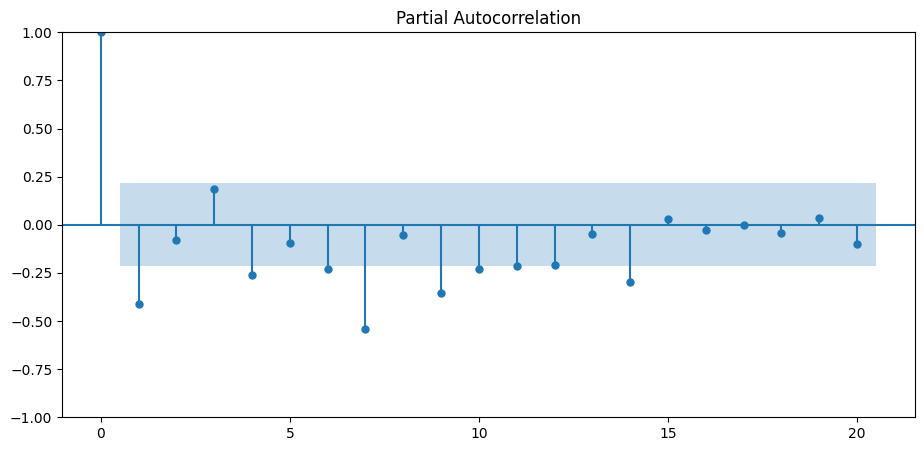

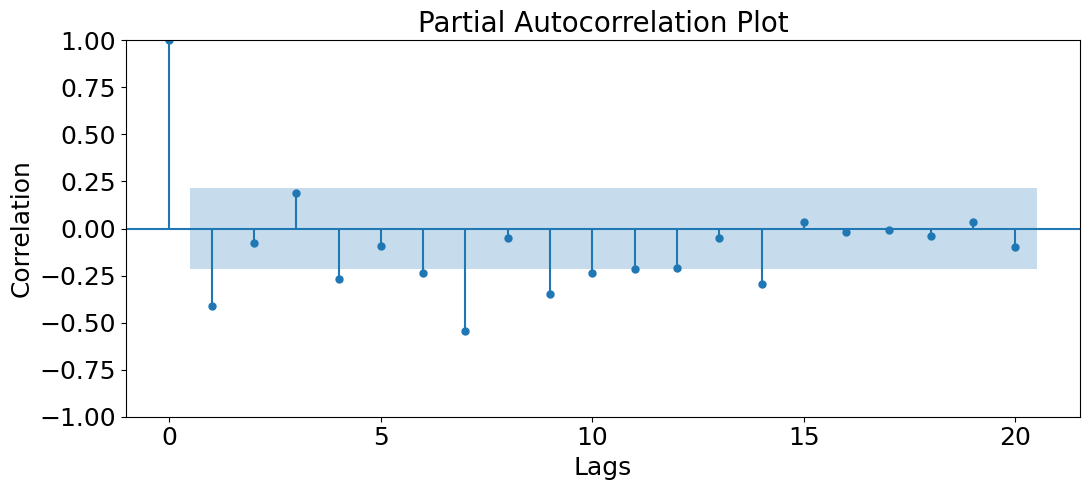

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
# Plot partial autocorrelation
plt.rc("figure", figsize=(11,5))
plot_pacf(data['mp_conc_diff'], method='ywm')
plot_pacf(data['mp_conc_logndiff'], method='ywm')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Partial Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

Lag 1 is highly correlated. 
This shows the seasonal effect of about 14 months. 

## ARIMA

In [10]:
import pandas as pd
data = pd.read_csv('/Users/autinauyeung/arima-mircoplastic/mp_conc_monthly_full.csv')

In [11]:
from statsmodels.tsa.arima.model import ARIMA

train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

arima_1 = ARIMA(train.mp_concentration, order=(14,1,8)).fit()
arima_forecasts_1 = arima_1.forecast(len(test))

arima_2 = ARIMA(train.mp_concentration, order=(14,1,9)).fit()
arima_forecasts_2 = arima_2.forecast(len(test))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.p

In [12]:
import plotly.graph_objects as go
import nbformat

def plot_forecasts(forecasts_1: list[float], forecasts_2: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['mp_concentration'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['mp_concentration'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts_1, name='Forecast 1'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts_2, name='Forecast 2'))
    fig.update_layout(template="simple_white", font=dict(size=10), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Average Microplastic Concentration')

    return fig.show()


# Plot the forecasts
plot_forecasts(arima_forecasts_1, arima_forecasts_2, 'mp_concentration ARIMA')

## Metrics

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def calculate_mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Remove zeros from y_true to avoid division by zero
    mask = y_true != 0
    if not np.any(mask):
        return np.inf
    
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    # Calculate MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

def calculate_smape(y_true, y_pred):
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate SMAPE
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    
    # Handle division by zero
    mask = denominator != 0
    if not np.any(mask):
        return np.inf
    
    smape = np.mean(numerator[mask] / denominator[mask]) * 100
    return smape

def calculate_msle(y_true, y_pred):
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Ensure all values are positive
    if np.any(y_true <= 0) or np.any(y_pred <= 0):
        raise ValueError("MSLE requires all values to be positive")
    
    # Calculate MSLE
    msle = np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2)
    return msle

In [14]:
arima_forecasts_2

67    14.536691
68    14.506055
69    14.544207
70    14.526995
71    14.530339
72    14.517023
73    14.496892
74    14.536853
75    14.523637
76    14.537797
77    14.531247
78    14.553428
79    14.514327
80    14.522622
81    14.505788
82    14.521137
Name: predicted_mean, dtype: float64

In [15]:
y_true = test['mp_concentration']
y_pred = arima_forecasts_1
    
print("ARIMA Forecast 1 Metrics:")
print("=" * 50)
    
print(f"MAE: {calculate_mae(y_true, y_pred):.4f}")
print(f"MSE: {calculate_mse(y_true, y_pred):.4f}")
print(f"RMSE: {calculate_rmse(y_true, y_pred):.4f}")
print(f"MAPE: {calculate_mape(y_true, y_pred):.4f}%")
print(f"SMAPE: {calculate_smape(y_true, y_pred):.4f}%")
print(f"MSLE: {calculate_msle(y_true, y_pred):.4f}")

y_true = test['mp_concentration']
y_pred = arima_forecasts_2
    
print()
print("ARIMA Forecast 2 Metrics:")
print("=" * 50)
    
print(f"MAE: {calculate_mae(y_true, y_pred):.4f}")
print(f"MSE: {calculate_mse(y_true, y_pred):.4f}")
print(f"RMSE: {calculate_rmse(y_true, y_pred):.4f}")
print(f"MAPE: {calculate_mape(y_true, y_pred):.4f}%")
print(f"SMAPE: {calculate_smape(y_true, y_pred):.4f}%")
print(f"MSLE: {calculate_msle(y_true, y_pred):.4f}")

ARIMA Forecast 1 Metrics:
MAE: 0.1361
MSE: 0.0214
RMSE: 0.1464
MAPE: 0.9272%
SMAPE: 0.9322%
MSLE: 0.0001

ARIMA Forecast 2 Metrics:
MAE: 0.1387
MSE: 0.0218
RMSE: 0.1475
MAPE: 0.9446%
SMAPE: 0.9497%
MSLE: 0.0001


## SARIMA

In [16]:
sarima_1 = ARIMA(train.mp_concentration, order=(2,1,8), seasonal_order=(1,1,1,12)).fit()
sarima_forecasts_1 = sarima_1.forecast(len(test))

sarima_2 = ARIMA(train.mp_concentration, order=(2,1,9), seasonal_order=(1,1,1,12)).fit()
sarima_forecasts_2 = sarima_2.forecast(len(test))

plot_forecasts(sarima_forecasts_1, sarima_forecasts_2, 'mp_concentration SARIMA')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [17]:
y_true = test['mp_concentration']
y_pred = sarima_forecasts_1

print("SARIMA Forecast 1 Metrics:")
print("=" * 50)
    
print(f"MAE: {calculate_mae(y_true, y_pred):.4f}")
print(f"MSE: {calculate_mse(y_true, y_pred):.4f}")
print(f"RMSE: {calculate_rmse(y_true, y_pred):.4f}")
print(f"MAPE: {calculate_mape(y_true, y_pred):.4f}%")
print(f"SMAPE: {calculate_smape(y_true, y_pred):.4f}%")
print(f"MSLE: {calculate_msle(y_true, y_pred):.4f}")

y_true = test['mp_concentration']
y_pred = sarima_forecasts_2

print()
print("SARIMA Forecast 2 Metrics:")
print("=" * 50)
    
print(f"MAE: {calculate_mae(y_true, y_pred):.4f}")
print(f"MSE: {calculate_mse(y_true, y_pred):.4f}")
print(f"RMSE: {calculate_rmse(y_true, y_pred):.4f}")
print(f"MAPE: {calculate_mape(y_true, y_pred):.4f}%")
print(f"SMAPE: {calculate_smape(y_true, y_pred):.4f}%")
print(f"MSLE: {calculate_msle(y_true, y_pred):.4f}")

SARIMA Forecast 1 Metrics:
MAE: 0.1989
MSE: 0.0442
RMSE: 0.2103
MAPE: 1.3553%
SMAPE: 1.3657%
MSLE: 0.0002

SARIMA Forecast 2 Metrics:
MAE: 0.1463
MSE: 0.0247
RMSE: 0.1570
MAPE: 0.9969%
SMAPE: 1.0026%
MSLE: 0.0001


## ARIMAX

In [18]:
import numpy as np
print(np.__version__)

1.26.4


In [19]:
import pmdarima as pm



In [21]:
# Read in the data
data = pd.read_csv('mp_conc_monthly_full.csv')
data['time'] = pd.to_datetime(data['time'])
data['month_num'] = data['time'].dt.month

# # Stabilise the variance
data.dropna()
data

,time,mp_concentration,month_num
0,2018-08-31,14.794952,8
1,2018-09-30,14.756403,9
2,2018-10-31,14.702092,10
3,2018-11-30,14.912478,11
4,2018-12-31,14.750171,12
...,...,...,...
78,2025-02-28,14.657710,2
79,2025-03-31,14.687917,3
80,2025-04-30,14.663004,4
81,2025-05-31,14.579799,5


In [22]:
# Get fourier features
for order in range(1, 10):
    data[f'fourier_sin_order_{order}'] = np.sin(2 * np.pi * order * data['month_num'] / 12)
    data[f'fourier_cos_order_{order}'] = np.cos(2 * np.pi * order * data['month_num'] / 12)

# name of fourier features
fourier_features = [i for i in list(data) if i.startswith('fourier')]

# Split train and test
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

# Build auto-ARIMA model with fourier features
arimax = pm.auto_arima(train['mp_concentration'],
                      X=train[fourier_features],
                      seasonal=False,
                      stepwise=True,
                      suppress_warnings=True,
                      max_order=None,
                      information_criterion='aicc',
                      error_action="ignore")

# Get the forecasts and apply inverse box-cox transform
arimax_forecasts = arimax.predict(n_periods=len(test), X=test[fourier_features])

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: Future

In [23]:
import plotly.graph_objects as go
import nbformat

def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['mp_concentration'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['mp_concentration'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(arimax_forecasts, 'Harmonic Regression')

In [24]:
y_true = test['mp_concentration']
y_pred = arimax_forecasts

print()
print("ARIMAX Metrics:")
print("=" * 50)
    
print(f"MAE: {calculate_mae(y_true, y_pred):.4f}")
print(f"MSE: {calculate_mse(y_true, y_pred):.4f}")
print(f"RMSE: {calculate_rmse(y_true, y_pred):.4f}")
print(f"MAPE: {calculate_mape(y_true, y_pred):.4f}%")
print(f"SMAPE: {calculate_smape(y_true, y_pred):.4f}%")
print(f"MSLE: {calculate_msle(y_true, y_pred):.4f}")


ARIMAX Metrics:
MAE: 0.1237
MSE: 0.0171
RMSE: 0.1309
MAPE: 0.8430%
SMAPE: 0.8470%
MSLE: 0.0001


## Forecasting Metrics

In [25]:
def calculate_all_metrics(y_true, y_pred):
    metrics = {
        'MAE': calculate_mae(y_true, y_pred),
        'MSE': calculate_mse(y_true, y_pred),
        'RMSE': calculate_rmse(y_true, y_pred),
        'MAPE': calculate_mape(y_true, y_pred),
        'SMAPE': calculate_smape(y_true, y_pred),
        'MSLE': calculate_msle(y_true, y_pred)
    }
    return metrics

In [26]:
from scipy.stats import pearsonr
results = []

metrics_arima = calculate_all_metrics(test['mp_concentration'],arima_forecasts_1)
metrics_arima['Model'] = 'ARIMA (forecast 1)'
metrics_arima['Pearson'] = pearsonr(test['mp_concentration'],arima_forecasts_1)[0]

results.append(metrics_arima)

metrics_arima = calculate_all_metrics(test['mp_concentration'],arima_forecasts_2)
metrics_arima['Model'] = 'ARIMA (forecast 2)'
metrics_arima['Pearson'] = pearsonr(test['mp_concentration'],arima_forecasts_2)[0]
results.append(metrics_arima)

metrics_arima = calculate_all_metrics(test['mp_concentration'],sarima_forecasts_1)
metrics_arima['Model'] = 'SARIMA (forecast 1)'
metrics_arima['Pearson'] = pearsonr(test['mp_concentration'],sarima_forecasts_1)[0]
results.append(metrics_arima)

metrics_arima = calculate_all_metrics(test['mp_concentration'],sarima_forecasts_2)
metrics_arima['Model'] = 'SARIMA (forecast 2)'
metrics_arima['Pearson'] = pearsonr(test['mp_concentration'],sarima_forecasts_2)[0]
results.append(metrics_arima)

metrics_arimax = calculate_all_metrics(test['mp_concentration'],arimax_forecasts)
metrics_arimax['Model'] = 'ARIMAX'
metrics_arima['Pearson'] = pearsonr(test['mp_concentration'],arimax_forecasts)[0]
results.append(metrics_arimax)

In [27]:
# Create DataFrame and set 'Model' as the index
metrics_df = pd.DataFrame(results).set_index('Model')

# Display the table
display(metrics_df)

,MAE,MSE,RMSE,MAPE,SMAPE,MSLE,Pearson
Model,,,,,,,
ARIMA (forecast 1),0.136128,0.021422,0.146362,0.927175,0.932165,0.000088,-0.123730
ARIMA (forecast 2),0.138680,0.021766,0.147534,0.944638,0.949708,0.000089,0.032166
SARIMA (forecast 1),0.198941,0.044220,0.210285,1.355349,1.365681,0.000182,-0.281203
SARIMA (forecast 2),0.146345,0.024660,0.157036,0.996855,1.002604,0.000101,0.489258
ARIMAX,0.123733,0.017124,0.130859,0.842997,0.846987,0.000070,NaN


MAE - Mean Absolute Error 
- Average absolute difference between predicted and actual values


Mean Squared Error 
- Penalizes larger errors more heavily than MAE

Root Mean Square Error 
- Same units as original data, easier to interpret than MSE

MAPE - Mean Absolute Percentage Error 
- Percentage error, scale-independent